Mean Absolute Error: 4.81
Root Mean Squared Error: 6.91


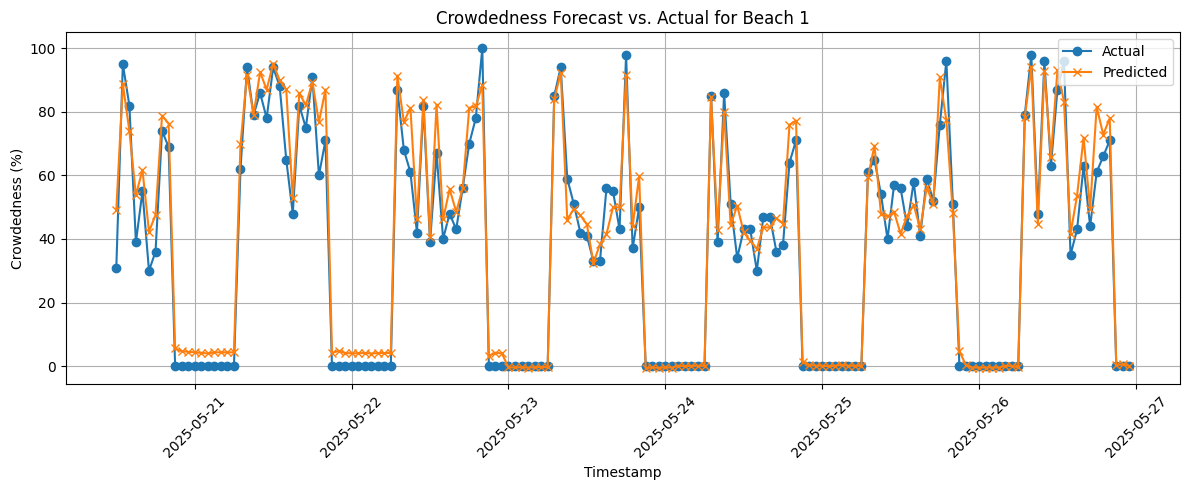

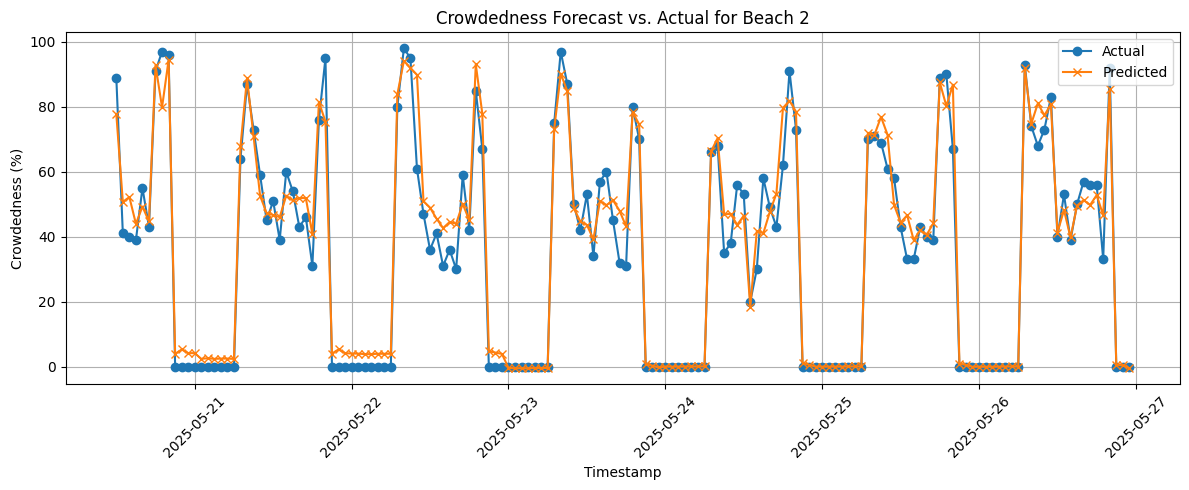

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import json
from sklearn.metrics import mean_absolute_error, mean_squared_error

csv_path = "../Data/dummy_data.csv"  
df = pd.read_csv(csv_path, parse_dates=['timestamp'])


# Feature Engineering
# Extract time-based features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.weekday  # Monday=0

# Encode hour and day cyclically
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# One-hot encode the weather column (categorical)
weather_dummies = pd.get_dummies(df['weather'].astype(str), prefix='weather')
df = pd.concat([df, weather_dummies], axis=1)
df.drop(columns=['weather'], inplace=True)

# Sort and compute lag/rolling features
df = df.sort_values(by=['beach_id', 'timestamp'])
df['crowdedness_lag_1'] = df.groupby('beach_id')['crowdedness_percentage'].shift(1)
df['crowdedness_roll_mean_3'] = df.groupby('beach_id')['crowdedness_percentage'].rolling(3).mean().reset_index(0, drop=True)

# Drop rows with NaNs from lag/rolling
df.dropna(inplace=True)


# Train/Test Split
train_df = df[df['timestamp'] < '2025-05-20 12:00:00']
test_df = df[df['timestamp'] >= '2025-05-20 12:00:00']
weather_features = [col for col in df.columns if col.startswith('weather_')]
features = [
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
    'is_holiday', 'sea_temp', 'wave_height', 'wind_speed',
    'crowdedness_lag_1', 'crowdedness_roll_mean_3'
] + weather_features
target = 'crowdedness_percentage'
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]


# XGBoost Model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train, y_train)


# Make Predictions
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# beach visualization
unique_beaches = test_df['beach_id'].unique()

for beach in unique_beaches:
    beach_mask = test_df['beach_id'] == beach
    plt.figure(figsize=(12, 5))
    plt.plot(test_df.loc[beach_mask, 'timestamp'], y_test.loc[beach_mask], label='Actual', marker='o')
    plt.plot(test_df.loc[beach_mask, 'timestamp'], preds[beach_mask], label='Predicted', marker='x')
    plt.title(f"Crowdedness Forecast vs. Actual for Beach {beach}")
    plt.xlabel("Timestamp")
    plt.ylabel("Crowdedness (%)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [8]:
model.save_model("crowd_forecast_model.json")
with open("feature_columns.json", "w") as f:
    json.dump(features, f)